# Collinear features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from rfpimp import *
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("data/rent.csv")
features = ['bathrooms','bedrooms','longitude','latitude', 'price']
df = df[features].copy()

# Clip to remove outliers
df = df[(df['latitude']>40.55) & (df['latitude']<40.94) &
        (df['longitude']>-74.1) & (df['longitude']<-73.67)]
df = df[(df.price>1_000) & (df.price<10_000)]

df_train, df_test = train_test_split(df, test_size=0.2)
X_train = df_train[['bedrooms','bathrooms','latitude','longitude']]
y_train = df_train['price']
X_test = df_test[['bedrooms','bathrooms','latitude','longitude']]
y_test = df_test['price']

rf = RandomForestRegressor(oob_score=True, n_estimators=100, n_jobs=-1)

## Drop column

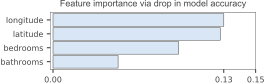

In [3]:
I = dropcol_importances(rf, X_train, y_train, X_test, y_test)
viz = plot_importances(I)
viz.save('../article/images/collinear_dropcol.svg')
viz

CPU times: user 28.2 s, sys: 744 ms, total: 28.9 s
Wall time: 6.4 s


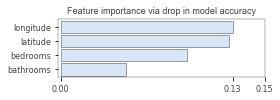

In [5]:
X_train_drop = X_train.copy()
X_train_drop['longitude_dup'] = X_train_drop.longitude
%time I = dropcol_importances(rf, X_train, y_train, X_test, y_test)
viz = plot_importances(I)
viz.save('../article/images/collinear_dropcol_longitude_dup.svg')
viz

CPU times: user 28.3 s, sys: 713 ms, total: 29 s
Wall time: 6.23 s


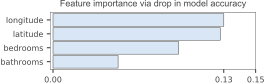

In [6]:
X_train_drop = X_train.copy()
X_train_drop['bathrooms_dup'] = X_train_drop.bathrooms
%time I = dropcol_importances(rf, X_train, y_train, X_test, y_test)
viz = plot_importances(I)
viz.save('../article/images/collinear_dropcol_bathrooms_dup.svg')
viz

## Validation set

In [7]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print(rf.oob_score_)

0.861613384771573


(9660, 4)


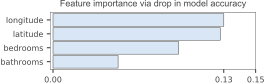

In [8]:
print(X_test.shape)
I = dropcol_importances(rf, X_train, y_train, X_test, y_test)

viz = plot_importances(I)
viz.save('../article/images/collinear_permute.svg')
viz

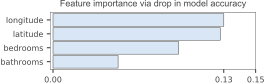

In [9]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
X_train_val = X_train.copy()
X_train_val['longitude_dup'] = X_train_val.longitude
rf.fit(X_train_val, y_train)
I = dropcol_importances(rf, X_train, y_train, X_test, y_test)
viz = plot_importances(I)
viz.save('../article/images/collinear_permute_longitude_dup.svg')
viz

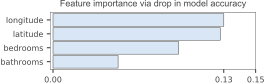

In [10]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
X_train_val = X_train.copy()
longitude_mean = np.mean(X_train_val.longitude)
longitude_range = max(X_train_val.longitude) - min(X_train_val.longitude)
# Range is .3938 so add uniform noise in range 0..c
c = .0005
noise = np.random.random(len(X_train_val))*c

X_train_val['longitude_noisy'] = X_train_val.longitude + noise
rf.fit(X_train_val, y_train)
I = dropcol_importances(rf, X_train, y_train, X_test, y_test)
viz = plot_importances(I)
viz.save(f'../article/images/collinear_permute_longitude_noise_{c:.4f}.svg')
viz

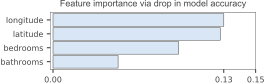

In [11]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
X_train_val = X_train.copy()
longitude_mean = np.mean(X_train_val.longitude)
longitude_range = max(X_train_val.longitude) - min(X_train_val.longitude)
# Range is like 0..8 so add uniform noise in range 0..c
c = 3
noise = np.random.random(len(X_train_val))*c

X_train_val['bedrooms_noisy'] = X_train_val.bedrooms + noise
rf.fit(X_train_val, y_train)
I = dropcol_importances(rf, X_train, y_train, X_test, y_test)
viz = plot_importances(I)
viz.save('../article/images/collinear_permute_bedrooms_noise_{c:.4f}.svg')
viz


# Gini decrease (Default importance)

In [12]:
def mkdf(columns, importances):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

In [20]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

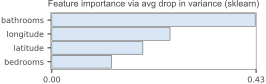

In [21]:
I = mkdf(X_train.columns,rf.feature_importances_)
viz = plot_importances(I, title="Feature importance via avg drop in variance (sklearn)")
viz.save('../article/images/collinear_dflt.svg')
viz

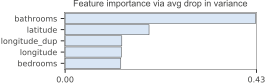

In [15]:
X_train_dflt = X_train.copy()
X_train_dflt['longitude_dup'] = X_train_dflt.longitude
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_dflt, y_train)

I = mkdf(X_train_dflt.columns,rf.feature_importances_)
viz = plot_importances(I, title="Feature importance via avg drop in variance (sklearn)")
viz.save('../article/images/collinear_dflt_longitude_dup.svg')
viz

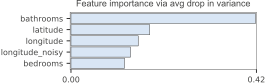

In [16]:
c = 0.0005
noise = np.random.random(len(X_train_val))*c

X_train_dflt = X_train.copy()
X_train_dflt['longitude_noisy'] = X_train_dflt.longitude + noise

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_dflt, y_train)

I = mkdf(X_train_dflt.columns,rf.feature_importances_)
viz = plot_importances(I, title="Feature importance via avg drop in variance")
viz.save(f'../article/images/collinear_dflt_longitude_noise_{c:.4f}.svg')
viz

## Cross validation

CPU times: user 53 s, sys: 1.32 s, total: 54.3 s
Wall time: 54.5 s


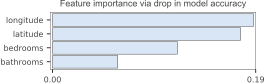

In [17]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
%time I = cv_importances(rf, X_train, y_train)
plot_importances(I)